In [1]:
# p67
# 記述統計とはデータセットに関する基本的な情報を示すもの
# データセット中に実際に実在するデータ数、列の平均値や標準偏差、そして最小値や最大値といった値が含まれる。

In [2]:
from pyspark.sql.types import IntegerType, StructField, StructType

rdd = sc.textFile('./data/ccFraud.csv')
header = rdd.first()
rdd = rdd.filter(lambda row: row != header) \
         .map(lambda row: [int(data) for data in row.split(',')])
    
fields = [
    StructField(data[1:-1], IntegerType(), True)
    for data in header.split(',')
]
schema = StructType(fields)
df = spark.createDataFrame(rdd, schema)
df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [3]:
df.groupBy('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [5]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = df.describe(numerical)
desc.show()

# わかること
# すべての列の歪度は正になっている。最大値は平均値の数倍以上になっている。
# 変動係数（標準偏差を算術平均で割った値）はきわめて高くなっている（1 に近いかそれ以上）。
# これはデータが広く分布していることを表している

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [9]:
# 歪度の確認

# データが正規分布しているかどうかを確認する指標の一つ。
# 分布の形状が左右対称かどうかの歪み具合を表す統計量で、
# 歪度が0のときに正規分布しているとみなされる。
# 歪度が0よりも大きいときは左に偏った分布
# 0よりも小さいときは右に偏った分布であることを意味する。
df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



In [11]:
# 相関

# ピアソン相関
df.corr('balance', 'numTrans')

0.0004452314017265387

In [18]:
# ペアワイズ相関

numerical_length = len(numerical)
corr = []
for i in range(0, numerical_length):
    tmp = [None] * i
    for j in range(i, numerical_length):
        print('pair is {} {}'.format(numerical[i], numerical[j]))
        tmp.append(df.corr(numerical[i], numerical[j]))
    corr.append(tmp)
corr

# 数値の列同士の相関がないことが読み取れるらしい
# したがってこれらの列はモデル内で使用できるものと判断できると解釈できる

pair is balance balance
pair is balance numTrans
pair is balance numIntlTrans
pair is numTrans numTrans
pair is numTrans numIntlTrans
pair is numIntlTrans numIntlTrans


[[1.0, 0.0004452314017265386, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

In [22]:
# 可視化

# jupyter で表示する用
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

([0.0, 2074.25, 4148.5, 6222.75, 8297.0, 10371.25, 12445.5, 14519.75, 16594.0, 18668.25, 20742.5, 22816.75, 24891.0, 26965.25, 29039.5, 31113.75, 33188.0, 35262.25, 37336.5, 39410.75, 41485], [3640021, 2258778, 1718633, 1035019, 601524, 343461, 192766, 104486, 54517, 27570, 13117, 5805, 2650, 1103, 358, 127, 45, 15, 1, 4])


Text(0.5, 1.0, "Histgram of 'balance'")

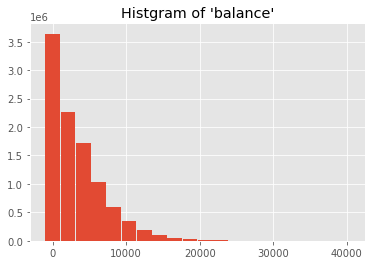

In [35]:
# ヒストグラム

# データの分布を可視化する
# ヒストグラムを作成する方法は3つある

# 1. ワーカーでデータを集計し、集計されたヒストグラムのリストをドライバに返させ、それぞれカウントする
# 2. すべてのデータポイントをドライバにかえっさせ、プロットを行うライブラリのメソッドにあとは任せる
# 3. データをサンプリングしてからドライバに返させ、プロットを行うライブラリのメソッドにあとは任せる

# データセットの中の行数が数十億に及ぶ場合 2 の選択肢は無理がある。
# 今回は 1 の方法をとる。

histgram = df.select('balance').rdd.flatMap(lambda row: row).histogram(20)
print(histgram)

data = {
    'bing': histgram[0][:-1],
    'freq': histgram[1],
}
plt.bar(data['bing'], data['freq'], width=2000)
plt.title("Histgram of 'balance'")

In [48]:
# 散布グラフ

# 散布グラフを使うと最大で3つの変数間の関係を一度に可視化できる。
# ただし、時系列データを扱い、時間の経過に伴う変化を観察したい場合を除けば、3Dで可視化することは滅多にない。
# 時系列データを扱う場合でも時系列データを区分けして、一連の2Dグラフとして見せるやり方もある。
# 3Dのグラフは複雑であり、多くの場合混乱を招く

# 数十億のデータをプロットするのは現実的では無い場合サンプリングする

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

# jupyter で表示する用
output_notebook()

sampled = df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)
multi_data = {
    element: sampled.select(element).rdd.flatMap(lambda row: row).collect()
    for element in ['balance', 'numTrans']
}

figure_plot = figure(
    x_axis_label='balance',
    y_axis_label='numTrans',
    plot_width=400,
    plot_height=400
)
figure_plot.circle(x=multi_data['balance'], y=multi_data['numTrans'], size=5)
show(figure_plot)

# 残高0 のトランザクションが多くみられる

Loading BokehJS ...